# Team Member：

107062514 賴鵬仁

107062616 傅品捷

107065513 姚定嘉

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ""
import tensorflow as tf
import pandas as pd
import numpy as np
import _pickle as cPickle

print("This notebook uses TensorFlow version {}".format(tf.__version__))

This notebook uses TensorFlow version 1.11.0


In [2]:
vocab = cPickle.load(open('dataset/text/vocab.pkl', 'rb'))
print('total {} vocabularies'.format(len(vocab)))

total 26900 vocabularies


In [3]:
def count_vocab_occurance(vocab, df):
    voc_cnt = {v: 0 for v in vocab}
    for img_id, row in df.iterrows():
        for w in row['caption'].split(' '):
            voc_cnt[w] += 1
    return voc_cnt


df_train = pd.read_csv(os.path.join('dataset', 'train.csv'))

print('count vocabulary occurances...')
voc_cnt = count_vocab_occurance(vocab, df_train)

# remove words appear < 50 times
thrhd = 50
x = np.array(list(voc_cnt.values()))
print('{} words appear >= 50 times'.format(np.sum(x[(-x).argsort()] >= thrhd)))

count vocabulary occurances...
3153 words appear >= 50 times


In [4]:
def build_voc_mapping(voc_cnt, thrhd):
    """
    enc_map: voc --encode--> id
    dec_map: id --decode--> voc
    """

    def add(enc_map, dec_map, voc):
        enc_map[voc] = len(dec_map)
        dec_map[len(dec_map)] = voc
        return enc_map, dec_map

    # add <ST>, <ED>, <RARE>
    enc_map, dec_map = {}, {}
    for voc in ['<ST>', '<ED>', '<RARE>']:
        enc_map, dec_map = add(enc_map, dec_map, voc)
    for voc, cnt in voc_cnt.items():
        if cnt < thrhd:  # rare words => <RARE>
            enc_map[voc] = enc_map['<RARE>']
        else:
            enc_map, dec_map = add(enc_map, dec_map, voc)
    return enc_map, dec_map


enc_map, dec_map = build_voc_mapping(voc_cnt, thrhd)
# save enc/decoding map to disk
cPickle.dump(enc_map, open('dataset/text/enc_map.pkl', 'wb'))
cPickle.dump(dec_map, open('dataset/text/dec_map.pkl', 'wb'))

In [5]:
def caption_to_ids(enc_map, df):
    img_ids, caps = [], []
    for idx, row in df.iterrows():
        icap = [enc_map[x] for x in row['caption'].split(' ')]
        icap.insert(0, enc_map['<ST>'])
        icap.append(enc_map['<ED>'])
        img_ids.append(row['img_id'])
        caps.append(icap)
    return pd.DataFrame({
              'img_id': img_ids,
              'caption': caps
            }).set_index(['img_id'])


enc_map = cPickle.load(open('dataset/text/enc_map.pkl', 'rb'))
print('[transform captions into sequences of IDs]...')
df_proc = caption_to_ids(enc_map, df_train)
df_proc.to_csv('dataset/text/train_enc_cap.csv')

[transform captions into sequences of IDs]...


In [6]:
df_cap = pd.read_csv(
    'dataset/text/train_enc_cap.csv')  # a dataframe - 'img_id', 'cpation'
enc_map = cPickle.load(
    open('dataset/text/enc_map.pkl', 'rb'))  # token => id
dec_map = cPickle.load(
    open('dataset/text/dec_map.pkl', 'rb'))  # id => token
vocab_size = len(dec_map)


def decode(dec_map, ids):
    """decode IDs back to origin caption string"""
    return ' '.join([dec_map[x] for x in ids])


print('decoding the encoded captions back...\n')
for idx, row in df_cap.iloc[:8].iterrows():
    print('{}: {}'.format(idx, decode(dec_map, eval(row['caption']))))

decoding the encoded captions back...

0: <ST> a group of three women sitting at a table sharing a cup of tea <ED>
1: <ST> three women wearing hats at a table together <ED>
2: <ST> three women with hats at a table having a tea party <ED>
3: <ST> several woman dressed up with fancy hats at a tea party <ED>
4: <ST> three women wearing large hats at a fancy tea event <ED>
5: <ST> a twin door refrigerator in a kitchen next to cabinets <ED>
6: <ST> a black refrigerator freezer sitting inside of a kitchen <ED>
7: <ST> black refrigerator in messy kitchen of residential home <ED>


In [7]:
len_list = []

for row in df_cap['caption']:
    len_list.append(len(eval(row)))

len_list = pd.DataFrame(len_list, columns=['cap_len'])

df_cap_sorted = pd.concat([df_cap, len_list], axis=1, join='inner')
df_cap_sorted = df_cap_sorted.sort_values(by = 'cap_len', ascending=True).drop('cap_len',axis =1)
df_cap_sorted.to_csv('dataset/text/train_enc_cap_sorted.csv', index=False)

def create_tfrecords(df_cap, img_df, filename, num_files=5):

    def _float_feature(value):
        return tf.train.Feature(float_list=tf.train.FloatList(value=value))

    def _int64_feature(value):
        return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

    num_records_per_file = df_cap.shape[0] // num_files

    total_count = 0

    print ("creat training dataset......")

    for i in range(num_files):
        count = 0
        writer = tf.python_io.TFRecordWriter(filename + '-' + str(i+1) + '.tfrecord')

        start = i * num_records_per_file
        end = (i+1) * num_records_per_file if i != num_files-1 else df_cap.shape[0]

        for idx, row in df_cap.iloc[start: end].iterrows():
            caption = eval(row['caption'])

            for _, inner_row in img_df[img_df['img_id'] == row['img_id']].iterrows():
                img_representation = inner_row['img']

                example = tf.train.Example(
                        features=tf.train.Features(feature={
                                'img': _float_feature(img_representation),
                                'caption': _int64_feature(caption)
                            })
                        )

                count += 1
                writer.write(example.SerializeToString())

        print ("create {}-{}.tfrecord -- contains {} records".format(filename, str(i+1), count))
        total_count += count
        writer.close()

    print ("Total records: {}".format(total_count))


df_cap = pd.read_csv('dataset/text/train_enc_cap_sorted.csv')
img_train = cPickle.load(open('dataset/train_img256.pkl', 'rb'))

img_train_df = pd.DataFrame(list(img_train.items()), columns=['img_id', 'img'])

create_tfrecords(df_cap, img_train_df, 'dataset/tfrecord/train', 10)

# Curricular Learning
在此我們按照notebook給的提示加上Curricular Learning，將字數短的視為簡單的task，長的視為難的task，讓model比較好train。

In [10]:
img_train = cPickle.load(open('dataset/train_img256.pkl', 'rb'))
# transform img_dict to dataframe
img_train_df = pd.DataFrame(list(img_train.items()), columns=['img_id', 'img'])
print('Images for training: {}'.format(img_train_df.shape[0]))

Images for training: 102739


In [11]:
import glob
training_filenames = glob.glob('dataset/tfrecords/train-*')

# get the number of records in training files
def get_num_records(files):
    count = 0
    for fn in files:
        for record in tf.python_io.tf_record_iterator(fn):
            count += 1
    return count

num_train_records = get_num_records(training_filenames)
print('Number of training records in all training file: {}'.format(
    num_train_records))

Number of training records in all training file: 513969


In [12]:
def training_parser(record):
    ''' parse record from .tfrecords file and create training record

    :args 
      record - each record extracted from .tfrecords
    :return
      a dictionary contains {
          'img': image array extracted from vgg16 (256-dim),
          'input_seq': a list of word id
                    which describes input caption sequence (Tensor),
          'output_seq': a list of word id
                    which describes output caption sequence (Tensor),
          'mask': a list of one which describe
                    the length of input caption sequence (Tensor)
      }
    '''

    keys_to_features = {
      "img": tf.FixedLenFeature([256], dtype=tf.float32),
      "caption": tf.VarLenFeature(dtype=tf.int64)
    }

    # features contains - 'img', 'caption'
    features = tf.parse_single_example(record, features=keys_to_features)

    img = features['img']
    caption = features['caption'].values
    caption = tf.cast(caption, tf.int32)

    # create input and output sequence for each training example
    # e.g. caption :   [0 2 5 7 9 1]
    #      input_seq:  [0 2 5 7 9]
    #      output_seq: [2 5 7 9 1]
    #      mask:       [1 1 1 1 1]
    caption_len = tf.shape(caption)[0]
    input_len = tf.expand_dims(tf.subtract(caption_len, 1), 0)

    input_seq = tf.slice(caption, [0], input_len)
    output_seq = tf.slice(caption, [1], input_len)
    mask = tf.ones(input_len, dtype=tf.int32)

    records = {
      'img': img,
      'input_seq': input_seq,
      'output_seq': output_seq,
      'mask': mask
    }

    return records

In [70]:
def tfrecord_iterator(filenames, batch_size, record_parser):
    ''' create iterator to eat tfrecord dataset 

    :args
        filenames     - a list of filenames (string)
        batch_size    - batch size (positive int)
        record_parser - a parser that read tfrecord
                        and create example record (function)

    :return 
        iterator      - an Iterator providing a way
                        to extract elements from the created dataset.
        output_types  - the output types of the created dataset.
        output_shapes - the output shapes of the created dataset.
    '''
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(record_parser, num_parallel_calls=16)

    # padded into equal length in each batch
    dataset = dataset.padded_batch(
      batch_size=batch_size,
      padded_shapes={
          'img': [None],
          'input_seq': [None],
          'output_seq': [None],
          'mask': [None]
      },
      padding_values={
          'img': 1.0,       # needless, for completeness
          'input_seq': 1,   # padding input sequence in this batch
          'output_seq': 1,  # padding output sequence in this batch
          'mask': 0         # padding 0 means no words in this position
      })  

    dataset = dataset.repeat()             # repeat dataset infinitely
    dataset = dataset.shuffle(10*batch_size)  # shuffle the dataset

    iterator = dataset.make_initializable_iterator()
    output_types = dataset.output_types
    output_shapes = dataset.output_shapes
    return iterator, output_types, output_shapes

因為使用Curricular Learning，model吃到的data都是先從字數少的開始，再慢慢到字數多的data，後來我們認為這樣model可能會學習到"先短再長"的order，導致generalizability不好，所以我們在training時，在dataset.shuffle()的buffer size先設為1 * batch_size，然後漸漸增加buffer size，使data可以洗更亂，避免上述問題，實驗結果發現此方法是可行的。

In [71]:
class ImageCaptionModel(object):
    ''' simple image caption model '''

    def __init__(self, hparams, mode):
        self.hps = hparams
        self.mode = mode
        self.ckpt_dir = './model/'
    def _build_inputs(self):
        """ construct the inputs for model """
        
        if self.mode == 'train':
            self.filenames = tf.placeholder(tf.string,
                                        shape=[None], name='filenames')
            self.training_iterator, types, shapes = tfrecord_iterator(
            self.filenames, self.hps.batch_size, training_parser)
                
            self.handle = tf.placeholder(tf.string, shape=[], name='handle')
            iterator = tf.data.Iterator.from_string_handle(self.handle,
                                                       types, shapes)
            records = iterator.get_next()
            image_embed = records['img']
            image_embed.set_shape([None, self.hps.image_embedding_size])
            input_seq = records['input_seq']
            target_seq = records['output_seq']
            input_mask = records['mask']
            
        else:
            self.image_embed_feed = tf.placeholder(dtype=tf.float32, shape=[None, self.hps.image_embedding_size],
                                              name="image_embed_feed")
        
            self.input_seq_feed = tf.placeholder(dtype=tf.int32, shape=[None],
                                              name="input_seq_feed")
            input_seq = tf.expand_dims(self.input_seq_feed, axis=1)
            image_embed = self.image_embed_feed
            #input_seq = self.input_seq_feed
            target_seq = None
            input_mask = None
            
        self.image_embed = image_embed # (batch_size, img_dim)
        self.input_seq = input_seq # (batch_size, seqlen)
        self.target_seq = target_seq # (batch_size, seqlen)
        self.input_mask = input_mask # (batch_size, seqlen)
                
        # convert sequence of index to sequence of embedding
    def _build_seq_embeddings(self):
        with tf.variable_scope('seq_embedding') as scope, tf.device('/cpu:0'):
            embedding_matrix = tf.get_variable(
                  name='embedding_matrix',
                  shape=[self.hps.vocab_size, self.hps.word_embedding_size],
                  initializer=tf.random_uniform_initializer(minval=-1, maxval=1))
            # [batch_size, padded_length, embedding_size]
            seq_embeddings = tf.nn.embedding_lookup(embedding_matrix, self.input_seq)
            scope.reuse_variables()
        self.seq_embeddings = seq_embeddings
            
    def _build_model(self):
        """ Build your image caption model """
        lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=self.hps.rnn_units, state_is_tuple=True)
        
        if self.mode == 'train':
            lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell,
            input_keep_prob=self.hps.drop_keep_prob,
            output_keep_prob=self.hps.drop_keep_prob)
            
        with tf.variable_scope("lstm", initializer=tf.random_uniform_initializer(
                        minval=-1, maxval=1)) as lstm_scope:
            zero_state = lstm_cell.zero_state(batch_size=tf.shape(self.image_embed)[0], dtype=tf.float32)###
            _, initial_state = lstm_cell(self.image_embed, zero_state)
                        
            lstm_scope.reuse_variables()
            
            if self.mode == 'inference':
                # In inference mode, use concatenated states for convenient feeding and
                # fetching.
                self.concat_init_state = tf.concat(axis=1, values=initial_state, name="initial_state")

                # Placeholder for feeding a batch of concatenated states.
                self.state_feed = tf.placeholder(dtype=tf.float32,
                                            shape=[None, sum(lstm_cell.state_size)],
                                            name="state_feed")
                state_tuple = tf.split(value=self.state_feed, num_or_size_splits=2, axis=1)

                # Run a single LSTM step.
                lstm_outputs, state_tuple = lstm_cell(
                    inputs=tf.squeeze(self.seq_embeddings, axis=[1]),
                    state=state_tuple)

                # Concatentate the resulting state.
                self.concat_output_state = tf.concat(axis=1, values=state_tuple, name="state")
                
            else:
                sequence_length = tf.reduce_sum(self.input_mask, 1)
                lstm_outputs, _ = tf.nn.dynamic_rnn(cell=lstm_cell,
                                                    inputs=self.seq_embeddings,
                                                    sequence_length=sequence_length,
                                                    initial_state=initial_state,
                                                    dtype=tf.float32,
                                                    scope=lstm_scope)
        
        lstm_outputs = tf.reshape(lstm_outputs, [-1, lstm_cell.output_size])
        
        with tf.variable_scope("logits") as logits_scope:
            logits = tf.contrib.layers.fully_connected(
            inputs=lstm_outputs,
            num_outputs=self.hps.vocab_size,
            activation_fn=None,
            weights_initializer=tf.random_uniform_initializer(minval=-1, maxval=1),
            scope=logits_scope)
            
        if self.mode == 'inference':
            self.softmax_output = tf.nn.softmax(logits, name="softmax")
            self.prediction = tf.argmax(self.softmax_output, axis=1, name='prediction')
        else:
            targets = tf.reshape(self.target_seq, [-1])
            weights = tf.cast(tf.reshape(self.input_mask, [-1]), tf.float32)
            losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets,logits=logits)
            self.batch_loss = tf.div(tf.reduce_sum(tf.multiply(losses, weights)),
                          tf.reduce_sum(weights),
                          name="batch_loss")
            
            #tf.losses.add_loss(self.batch_loss)
            #total_loss = tf.losses.get_total_loss()
            self.total_loss = self.batch_loss
            self.target_cross_entropy_losses = losses  # Used in evaluation.
            self.target_cross_entropy_loss_weights = weights  # Used in evaluation.
            
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.hps.lr)
            grads_and_vars = optimizer.compute_gradients(self.total_loss,
                                             tf.trainable_variables())
            clipped_grads_and_vars = [(tf.clip_by_norm(gv[0], 1.0), gv[1])
                          for gv in grads_and_vars]
            self.train_op = optimizer.apply_gradients(clipped_grads_and_vars)
            
        
        
        pass
        
    def build(self):
        """ call this function to build the inputs and model """
        self._build_inputs()
        self._build_seq_embeddings()
        self._build_model()

        
    def train(self, sess, training_filenames, num_train_records):
        """ write a training function for your model """
        self.saver = tf.train.Saver()
        
        self.mode = "train"
        ckpt = tf.train.get_checkpoint_state(self.hps.ckpt_dir)
        ckpt_path = self.ckpt_dir
        if ckpt and ckpt.model_checkpoint_path:
            # if checkpoint exists
            #saver.restore(sess, ckpt.model_checkpoint_path)
            #####saver.restore(sess, ckpt_path)
                
            self.saver.restore(sess, tf.train.latest_checkpoint(ckpt_path))
                
            # assume the name of checkpoint is like '.../model.ckpt-1000'
            #####gs = int(ckpt_path.split('/')[-1].split('-')[-1])
            #gs = int(ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1])
            #sess.run(tf.assign(global_step, gs))
        else:
            # no checkpoint
            sess.run(tf.global_variables_initializer())
        
        
    
        ##ˇsess.run(tf.global_variables_initializer())
        batch_num = num_train_records//self.hps.batch_size
        
        training_handle = sess.run(self.training_iterator.string_handle())
        sess.run(self.training_iterator.initializer,feed_dict={self.filenames: training_filenames})
        
        for e in range(self.hps.training_epochs):
            train_loss = 0
            for b in range(batch_num):
                loss, _ = sess.run([self.total_loss, self.train_op], feed_dict={self.handle:training_handle})
                train_loss += loss

            if e % 10 == 0:
                self.saver.save(sess, 'model/model_%d.ckpt'%(e))
            print("epoch %d loss: %f" % (e, train_loss))
            
        pass
    
    def predict(self, sess, img_vec, dec_map):
        """ generate the caption given an image """
        self.mode = "inference"
        caption_id = []
        
        '''stack elements to match the batch size
        
        def get_duplicate_form(element): 
            elements = []
            for i in range(self.hps.batch_size):
                elements.append(element)
            elements = np.array(elements)
            return elements
        '''
        #img_vecs = get_duplicate_form(img_vec)
        st = [enc_map['<ST>']]
        
        #st = get_duplicate_form([enc_map['<ST>']])
        
        concat_init_state = sess.run(self.concat_init_state, feed_dict={self.image_embed_feed:img_vec})
        
        next_input,concat_output_state = sess.run([self.prediction,self.concat_output_state],
                                  feed_dict={self.input_seq_feed:st, self.state_feed:concat_init_state})
        
        #softmax_output = sess.run(self.softmax_output, feed_dict={self.input_seq_feed:st, self.state_feed:concat_init_state})
        
        #pre_state = concat_output_state
        #next_input = np.argmax(softmax_output[0])
        caption_id.append(int(next_input))
        
        for i in range(self.hps.max_caption_len - 1):
            # st= get_duplicate_form([next_input])
            #st = next_input
            next_input,concat_output_state = sess.run([self.prediction,self.concat_output_state],
                                          feed_dict={self.input_seq_feed:next_input, self.state_feed:concat_output_state})

            #softmax_output = sess.run(self.softmax_output, feed_dict={self.image_embed_feed:img_vecs,
            #                                         self.input_seq_feed:st, self.state_feed:pre_state}) 
            
            #pre_state = concat_output_state
            #next_input = np.argmax(softmax_output[0])
            caption_id.append(int(next_input))
            #if(dec_map[next_input] == '<ED>'):
            #break
        #caption.append(dec_map[next_input])
        caption = [
                dec_map[x]
                for x in caption_id[:None
                                    if enc_map['<ED>'] not in caption_id else caption_id.index(enc_map['<ED>'])]    
        ]
        return ' '.join(caption)    
    
    def restore(self,sess, e):
        self.saver.restore(sess, 'model/model_%d.ckpt'%(e))
        

# Build the model
show and tell model。我們按照助教給的Hint，加入Gradient-Clipping，防止梯度爆炸的問題，正如老師上課所說LSTM + Gradient-Clipping是個好的組合，這裡我們沒有使用Attention machanism，inference也沒有使用Beam search，只用最簡單的greedy。

In [72]:
def get_hparams():
    hparams = tf.contrib.training.HParams(
      vocab_size=vocab_size,
      batch_size=64,
      rnn_units=256,
      image_embedding_size=256,
      word_embedding_size=256,
      drop_keep_prob=0.7,
      lr=1e-5,
      training_epochs=101,
      max_caption_len=15,
      ckpt_dir='model/')
    return hparams
# get hperparameters
hparams = get_hparams()
# create model
tf.reset_default_graph()




這裡我們把rnn_unit從100改成256，讓LSTM的capacity增加，希望可以使performance更好。

In [73]:
model = ImageCaptionModel(hparams, 'train')
model.build()
# start training
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
model.train(sess, training_filenames, num_train_records)

INFO:tensorflow:Restoring parameters from ./model/model_100.ckpt
epoch 0 loss: 21404.259413
epoch 1 loss: 20927.326910
epoch 2 loss: 20608.918218
epoch 3 loss: 20512.934898
epoch 4 loss: 20456.215910
epoch 5 loss: 20405.894823
epoch 6 loss: 20394.569171
epoch 7 loss: 20382.877614
epoch 8 loss: 20361.770439
epoch 9 loss: 20365.393644
epoch 10 loss: 20361.717659
epoch 11 loss: 20366.450012
epoch 12 loss: 20364.004521
epoch 13 loss: 20340.287861
epoch 14 loss: 20345.051438
epoch 15 loss: 20343.848436
epoch 16 loss: 20339.081120
epoch 17 loss: 20339.734980
epoch 18 loss: 20339.048450
epoch 19 loss: 20331.944392
epoch 20 loss: 20333.622939
epoch 21 loss: 20313.178636
epoch 22 loss: 20344.359597
epoch 23 loss: 20320.337561
epoch 24 loss: 20316.496462
epoch 25 loss: 20313.385135
epoch 26 loss: 20310.332893
epoch 27 loss: 20311.916967
epoch 28 loss: 20321.132531
epoch 29 loss: 20311.296660
epoch 30 loss: 20301.419603
epoch 31 loss: 20302.070383
epoch 32 loss: 20302.818284
epoch 33 loss: 20298.

# Training
在此我們用我們上述提的假設(shuffle更亂)，陸續train了大約400個epochs，中間都有停掉再restore model，更改dataset.shuffle()的buffer size，再繼續train。我們到最後也有嘗試把Adam改成SGD，因為聽到上次第一名的分享，做了這樣的嘗試。到後來loss一直降不下去，但是產生出來的score卻逐漸進步，我們認為training loss只是個參考的依據，並非最後決定結果好壞的絕對標準。

In [76]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
model = ImageCaptionModel(hparams, "inference")
model.build()
saver = tf.train.Saver()
saver.restore(sess, 'model/model_90.ckpt')

assert (hparams.rnn_units == hparams.image_embedding_size)
testimg = img_train_df.iloc[9]['img']
testimg = np.expand_dims(testimg, axis=0)
print(img_train_df.iloc[9]['img_id'])


c_list = model.predict(sess, testimg, dec_map)
caption = ''
for word in c_list:
    caption += word + ' '
print(caption)

INFO:tensorflow:Restoring parameters from model/model_90.ckpt
233954.jpg
a   l i v i n g   r o o m   w i t h   a   c o u c h   a n d   a   t e l e v i s i o n 


In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image, display
from pretrained.cnn import PretrainedCNN
import imageio
import skimage.transform
import numpy as np
import scipy

def demo(img_path, cnn_mdl, U, dec_map, hparams, max_len=15):
    """
    displays the caption generated for the image
    -------------------------------
    img_path: image to be captioned
    cnn_mdl: path of the image feature extractor
    U: transform matrix to perform PCA
    dec_map: mapping of vocabulary ID => token string
    hparams: hyperparams for model
    """

    def process_image(img, crop=True, submean=True):
        """
        implements the image preprocess required by VGG-16
        -------------------------------
        resize image to 224 x 224
        crop: do center-crop [skipped by default]
        submean: substracts mean image of ImageNet [skipped by default]
        """
        MEAN = np.array([103.939, 116.779, 123.68]).astype(np.float32) # BGR
        # center crop
        short_edge = min(img.shape[:2])
        yy = int((img.shape[0] - short_edge) / 2)
        xx = int((img.shape[1] - short_edge) / 2)
        crop_img = img[yy: yy + short_edge, xx: xx + short_edge]
        img = scipy.misc.imresize(crop_img, [224, 224, 3])
        img = img.reshape((224,224,1)) if len(img.shape) < 3 else img
        
        if img.shape[2] < 3:
            print('dimension insufficient')
            img = img.reshape((224*224,
                               img.shape[2])).T.reshape((img.shape[2],
                                                                 224*224))
            for i in range(img.shape[0], 3):
                img = np.vstack([img, img[0,:]])
            img = img.reshape((3,224*224)).T.reshape((224,224,3))
        img = img.astype(np.float32)
        img = img[:,:,::-1]
        # RGB => BGR
        for i in range(3):
            img[:,:,i] -= MEAN[i]
        return img.reshape((224,224,3))

    display(Image(img_path))
    img = imageio.imread(img_path)
    
    # load pretrained cnn model
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        img_feature = np.dot(
            cnn_mdl.get_output(sess, [process_image(img)])[0].reshape((-1)), U)
    img = np.expand_dims(img_feature, axis=0)    
    # reset graph for image caption model
    tf.reset_default_graph()  
    model = ImageCaptionModel(hparams,"inference")
    model.build()
    with tf.Session(config=config) as sess:
        saver = tf.train.Saver()
        saver.restore(sess, 'model/model_90.ckpt') 
        caption = model.predict(sess, img, dec_map)
        print(' '.join(caption))


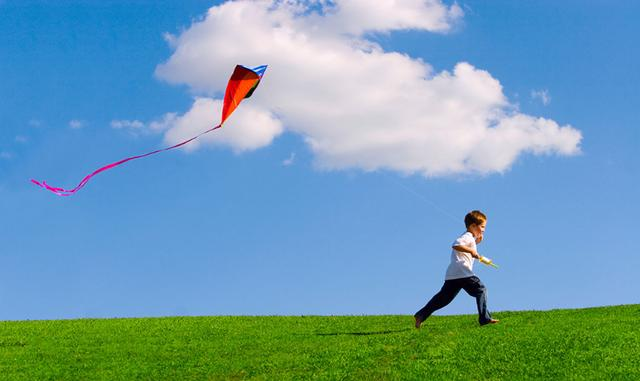

INFO:tensorflow:Restoring parameters from model/model_90.ckpt
a   m a n   i s   f l y i n g   a   k i t e   i n   t h e   a i r


In [78]:
tf.reset_default_graph()  # reset graph for cnn model
U = cPickle.load(open('dataset/U.pkl', 'rb'))  # PCA transforming matrix
vgg = PretrainedCNN('pretrained/vgg16_mat.pkl')
demo('demo/example3.jpg', vgg, U, dec_map, hparams)

可以看到generate出來的caption相當符合。

In [74]:
def generate_captions(model, dec_map, img_test, max_len=15):
    img_ids, caps = [], []
    saver = tf.train.Saver()
    sess = tf.Session()
    ckpt = tf.train.get_checkpoint_state('model/')
    ckpt_dir = 'model/'
    ckpt_path = ckpt_dir
    
    #saver.restore(sess, tf.train.latest_checkpoint(ckpt_path))'model/model_%d.ckpt'
    saver.restore(sess, 'model/model_100.ckpt')
    for img_id, img in img_test.items():
        img_ids.append(img_id)
        img = np.expand_dims(img, axis=0)
        caps.append(model.predict(sess, img, dec_map))
    
    return pd.DataFrame({
              'img_id': img_ids,
              'caption': caps
            }).set_index(['img_id'])


In [75]:
# load test image  size=20548
img_test = cPickle.load(open('dataset/test_img256.pkl', 'rb'))

# create model
tf.reset_default_graph()
model = ImageCaptionModel(hparams,'inference')
model.build()

# generate caption to csv file
df_predict = generate_captions(model, dec_map, img_test)
df_predict.to_csv('generated/demo.csv')


INFO:tensorflow:Restoring parameters from model/model_100.ckpt


In [ ]:
os.system('cd CIDErD_win && gen_score -i ../generated/demo.csv -r ../generated/score.csv')

我們在最後產生score.csv時出現了問題，只有一台電腦可以產生結果，我們到最後還是沒有解決這個問題。

# Conclusion
今天聽完前三名的分享後，首先，發現大家除了試過助教給的CNN外，都有再用更厲害的CNN model 去抽出image 的 representation，representation都比助教給的256維還要大很多，rnn_unit也調成2048，使model的效果進步很多；第二，他們也使用了multilayer的rnn cell或bidirectional RNN去implement，且在每一層都加上了batch norm，使效果更好；第三，他們都有按照助教給的hints，加上Attention或是在Inference時使用beam search。聽完這次分享，前三名的組別都注意到了很多能使效果更好的細節，並且花了許多心力在找尋使效果更好的方法，希望我們下次能夠吸取他們的經驗，拿到更好的表現。